In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! unzip '/content/drive/MyDrive/University/Class/[Techainer] Coding Bootcamp - AI/day 4 basic deep learning 2/VN-Celeb/VN-celeb.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/VN-celeb/100/15.png  
  inflating: /content/VN-celeb/100/16.png  
  inflating: /content/VN-celeb/100/17.png  
  inflating: /content/VN-celeb/100/18.png  
  inflating: /content/VN-celeb/100/19.png  
   creating: /content/VN-celeb/340/
  inflating: /content/VN-celeb/340/0.png  
  inflating: /content/VN-celeb/340/1.png  
 extracting: /content/VN-celeb/340/2.png  
  inflating: /content/VN-celeb/340/3.png  
 extracting: /content/VN-celeb/340/4.png  
   creating: /content/VN-celeb/825/
  inflating: /content/VN-celeb/825/0.png  
  inflating: /content/VN-celeb/825/1.png  
 extracting: /content/VN-celeb/825/2.png  
 extracting: /content/VN-celeb/825/3.png  
  inflating: /content/VN-celeb/825/4.png  
  inflating: /content/VN-celeb/825/5.png  
  inflating: /content/VN-celeb/825/6.png  
 extracting: /content/VN-celeb/825/7.png  
  inflating: /content/VN-celeb/825/8.png  
  inflating: /content/VN-celeb/825/9.png  
 extracting:

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import glob
import os
import pandas as pd
import cv2

In [4]:
path_dir = '/content/VN-celeb/'

x = 500
lst_id = list(map(str, range(x, x+10)))

data_list = []
for i in lst_id:
  data_list.extend(glob.glob(os.path.join(path_dir + i, '*.png')))

print('id:', lst_id)
print(len(data_list))
data_list[:5]

id: ['500', '501', '502', '503', '504', '505', '506', '507', '508', '509']
388


['/content/VN-celeb/500/25.png',
 '/content/VN-celeb/500/33.png',
 '/content/VN-celeb/500/32.png',
 '/content/VN-celeb/500/17.png',
 '/content/VN-celeb/500/2.png']

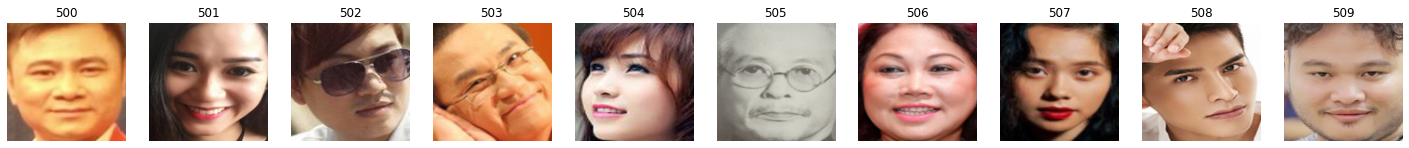

In [12]:
plt.figure(figsize=(25, 25))
for i, val in enumerate(lst_id):
  path = path_dir + str(val) + '/0.png'
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.subplot(1, 10, i+1)
  plt.imshow(img)
  plt.title(str(val))
  plt.axis('off')
plt.show()

In [ ]:
class CnnModel(nn.Module):
  def __init__(self, ch_in, n_class):
      super().__init__()
      self.network = nn.Sequential(
          nn.Conv2d(ch_in, 32, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

          nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

          nn.Flatten(), 
          nn.Linear(256*4*4, 1024),
          nn.ReLU(),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Linear(512, n_class))
      
  def forward(self, xb):
      return self.network(xb)

In [ ]:
class dataset(Dataset):
  def __init__(self, lst_path, label, transform = None):
    self.lst_path = lst_path
    self.label = label
    self.transform = transform
  
  def __len__(self):
    return len(self.lst_path)

  def __getitem__(self, idx):
    path = self.lst_path[idx]
    img = Image.open(path)
    if self.transform:
      img = self.transform(img)
    label = self.label.index(path.split('/')[-2])
    return img, label

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, device, epochs = 10):
  best_val_loss = float('inf')
  history={'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
  for epoch in tqdm(range(epochs), desc='Epoch'):
    train_loss = 0
    train_acc = 0
    model.train()
    for data, label in tqdm(train_loader, desc='Train', leave=False):
      data = data.to(device)
      label = label.to(device)

      optimizer.zero_grad()

      output = model(data)
      loss = criterion(output, label)

      loss.backward()
      optimizer.step() 

      train_loss += loss.cpu().detach().numpy()
      train_acc += (output.argmax(dim=1) == label).float().mean().cpu().detach().numpy()
    train_loss = train_loss/len(train_loader)
    train_acc = train_acc/len(train_loader)

    val_loss = 0
    val_acc = 0
    with torch.no_grad():
      model.eval()
      for data, label in tqdm(val_loader, desc='Valib', leave=False):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        val_loss += loss.cpu().detach().numpy()
        val_acc += (output.argmax(dim=1) == label).float().mean().cpu().detach().numpy()
      val_loss = val_loss/len(val_loader)
      val_acc = val_acc/len(val_loader)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(),'/content/model_face_classifile.pth')

    history['accuracy'].append(train_acc)
    history['loss'].append(train_loss)
    history['val_accuracy'].append(val_acc)
    history['val_loss'].append(val_loss)

    print(f'Epoch {epoch+1}:', f"train_acc: {train_acc}, train_loss: {train_loss}, val_acc: {val_acc}, val_loss: {val_loss}")
  return history

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = (32, 32)

In [ ]:
train_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                       transforms.ToTensor()
])

val_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                       transforms.ToTensor()
])

In [ ]:
train_lst, val_lst = train_test_split(data_list, test_size=0.2)
len(train_lst), len(val_lst)

(310, 78)

In [ ]:
train_data = dataset(train_lst, lst_id, train_transforms)
val_data = dataset(val_lst, lst_id, val_transforms)

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

In [ ]:
model = CnnModel(3, 10).to(device)
optimizer = optim.Adam(params = model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
history = train(model, train_loader, val_loader, optimizer, criterion, device, epochs=50)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: train_acc: 0.11392045468091964, train_loss: 2.302240014076233, val_acc: 0.22767857213815054, val_loss: 2.2798693974812827


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2: train_acc: 0.20710227340459825, train_loss: 2.24062716960907, val_acc: 0.2008928582072258, val_loss: 2.188893993695577


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3: train_acc: 0.20568181872367858, train_loss: 2.1905030488967894, val_acc: 0.2544642885526021, val_loss: 2.1288763682047525


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4: train_acc: 0.20994318127632142, train_loss: 2.1761762857437135, val_acc: 0.2142857164144516, val_loss: 2.137563149134318


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5: train_acc: 0.20426136404275894, train_loss: 2.165536403656006, val_acc: 0.2142857164144516, val_loss: 2.1472272078196206


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6: train_acc: 0.2085227280855179, train_loss: 2.16942822933197, val_acc: 0.2544642885526021, val_loss: 2.1078487237294516


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7: train_acc: 0.20142045468091965, train_loss: 2.1811182737350463, val_acc: 0.2544642885526021, val_loss: 2.12050731976827


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8: train_acc: 0.20710227340459825, train_loss: 2.1825477361679075, val_acc: 0.2142857164144516, val_loss: 2.1576667626698813


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9: train_acc: 0.20568181872367858, train_loss: 2.167820119857788, val_acc: 0.2410714328289032, val_loss: 2.098325490951538


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10: train_acc: 0.20994318127632142, train_loss: 2.1492149353027346, val_acc: 0.2544642885526021, val_loss: 2.1414901415506997


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11: train_acc: 0.20568181872367858, train_loss: 2.1419907569885255, val_acc: 0.22767857213815054, val_loss: 2.0913992722829184


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12: train_acc: 0.2088068187236786, train_loss: 2.1257465362548826, val_acc: 0.3467261989911397, val_loss: 2.0800766150156655


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13: train_acc: 0.2650568187236786, train_loss: 2.094958186149597, val_acc: 0.3110119054714839, val_loss: 2.0142876307169595


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14: train_acc: 0.2897727280855179, train_loss: 1.9843089938163758, val_acc: 0.3645833333333333, val_loss: 1.823428471883138


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15: train_acc: 0.3676136374473572, train_loss: 1.7970545172691346, val_acc: 0.3824404776096344, val_loss: 1.7373889684677124


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16: train_acc: 0.40056818127632143, train_loss: 1.6847881078720093, val_acc: 0.4449404776096344, val_loss: 1.7704245646794636


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17: train_acc: 0.40795454680919646, train_loss: 1.6181093335151673, val_acc: 0.3764880994955699, val_loss: 1.660964568456014


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18: train_acc: 0.4409090906381607, train_loss: 1.523960030078888, val_acc: 0.4613095323244731, val_loss: 1.589640736579895


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19: train_acc: 0.47386363744735716, train_loss: 1.4323205709457398, val_acc: 0.3273809552192688, val_loss: 1.8461097478866577


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20: train_acc: 0.4815340906381607, train_loss: 1.38820960521698, val_acc: 0.4613095323244731, val_loss: 1.5751276016235352


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21: train_acc: 0.496875, train_loss: 1.3207682609558105, val_acc: 0.4895833333333333, val_loss: 1.5451683203379314


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22: train_acc: 0.5625, train_loss: 1.2787105798721314, val_acc: 0.5104166666666666, val_loss: 1.3875557978947957


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23: train_acc: 0.5764204561710358, train_loss: 1.1476680159568786, val_acc: 0.4553571442763011, val_loss: 1.52159587542216


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24: train_acc: 0.5985795468091964, train_loss: 1.1137012124061585, val_acc: 0.4449404776096344, val_loss: 1.6363696654637654


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25: train_acc: 0.593465906381607, train_loss: 1.0677204191684724, val_acc: 0.5074404776096344, val_loss: 1.451411247253418


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26: train_acc: 0.6284090906381607, train_loss: 0.9834875345230103, val_acc: 0.4925595323244731, val_loss: 1.4128649234771729


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27: train_acc: 0.6451704561710357, train_loss: 0.9249087691307067, val_acc: 0.5029761989911398, val_loss: 1.6584022839864094


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28: train_acc: 0.655965906381607, train_loss: 0.8855676054954529, val_acc: 0.581845243771871, val_loss: 1.3648394346237183


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29: train_acc: 0.665340906381607, train_loss: 0.9049983024597168, val_acc: 0.4866071442763011, val_loss: 1.5174853404362996


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30: train_acc: 0.7178977251052856, train_loss: 0.7850368797779084, val_acc: 0.5714285771052042, val_loss: 1.346951683362325


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31: train_acc: 0.7426136374473572, train_loss: 0.6703499048948288, val_acc: 0.4627976218859355, val_loss: 1.5632059574127197


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32: train_acc: 0.8113636374473572, train_loss: 0.5752943813800812, val_acc: 0.5416666666666666, val_loss: 1.4706512292226155


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33: train_acc: 0.8164772748947143, train_loss: 0.5177978157997132, val_acc: 0.5416666666666666, val_loss: 1.7783252000808716


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34: train_acc: 0.8102272748947144, train_loss: 0.48375372886657714, val_acc: 0.5386904776096344, val_loss: 1.7181406021118164


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35: train_acc: 0.8150568187236786, train_loss: 0.44714822471141813, val_acc: 0.5267857114473978, val_loss: 1.7776953379313152


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36: train_acc: 0.8625, train_loss: 0.3643883362412453, val_acc: 0.5372023781140646, val_loss: 1.636760910352071


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37: train_acc: 0.906534093618393, train_loss: 0.31010776460170747, val_acc: 0.53125, val_loss: 1.9298692146937053


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38: train_acc: 0.9159090936183929, train_loss: 0.23223203867673875, val_acc: 0.555059532324473, val_loss: 1.871295690536499


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39: train_acc: 0.8988636374473572, train_loss: 0.2788084976375103, val_acc: 0.5446428656578064, val_loss: 2.0410099029541016


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40: train_acc: 0.9193181812763214, train_loss: 0.2332068234682083, val_acc: 0.5610119104385376, val_loss: 2.2312414248784385


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41: train_acc: 0.9096590936183929, train_loss: 0.27611667960882186, val_acc: 0.5967261989911398, val_loss: 1.979757269223531


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42: train_acc: 0.8943181812763215, train_loss: 0.2731303170323372, val_acc: 0.5416666666666666, val_loss: 2.1415623823801675


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43: train_acc: 0.9252840936183929, train_loss: 0.20538939163088799, val_acc: 0.5476190447807312, val_loss: 2.524707039197286


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44: train_acc: 0.95625, train_loss: 0.163652191311121, val_acc: 0.5625, val_loss: 2.4737361669540405


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45: train_acc: 0.9610795438289642, train_loss: 0.10987121798098087, val_acc: 0.5654761989911398, val_loss: 2.5393904050191245


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46: train_acc: 0.9798295438289643, train_loss: 0.09607897512614727, val_acc: 0.5967261989911398, val_loss: 2.682827949523926


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47: train_acc: 0.996875, train_loss: 0.04856380093842745, val_acc: 0.5208333333333334, val_loss: 3.1084508895874023


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48: train_acc: 0.996875, train_loss: 0.035190805420279504, val_acc: 0.5997023781140646, val_loss: 2.821860194206238


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49: train_acc: 0.996875, train_loss: 0.03151019318029284, val_acc: 0.5952380895614624, val_loss: 2.9379573663075766


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Valib:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50: train_acc: 0.996875, train_loss: 0.02082704482600093, val_acc: 0.5416666666666666, val_loss: 3.3708057403564453


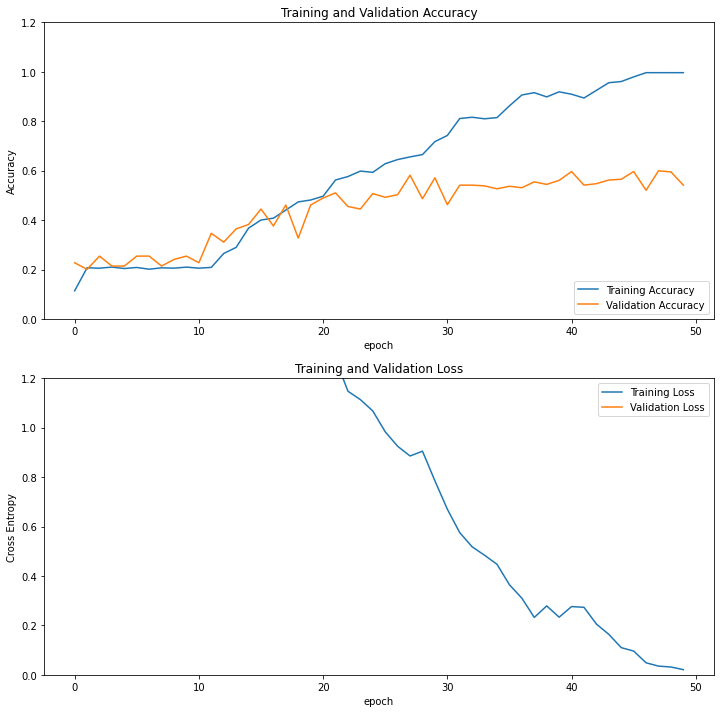

In [ ]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.2])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.2])
plt.title('Training and Validation Loss');

In [ ]:
model1 = CnnModel(3, 10).to(device)
model1.load_state_dict(torch.load('/content/model.pth'))

<All keys matched successfully>

In [ ]:
dct = {i:[0, 0, 0] for i in lst_id}
with torch.no_grad():
  model1.eval()
  for x, y in val_data:
    output = model1((x.view((1,) + x.shape)).to(device))
    dct[lst_id[y]][output.argmax(dim=1) == y] += 1

for i in dct:
  dct[i][2] = dct[i][1]/max(1.0, dct[i][0]+dct[i][1])

In [ ]:
result = pd.DataFrame(dct, index=('incorrect', 'correct', 'accuracy')).T
result

,incorrect,correct,accuracy
500,5.0,2.0,0.285714
501,0.0,2.0,1.000000
502,3.0,7.0,0.700000
503,2.0,5.0,0.714286
504,1.0,1.0,0.500000
505,0.0,1.0,1.000000
506,6.0,6.0,0.500000
507,6.0,4.0,0.400000
508,5.0,4.0,0.444444
509,8.0,10.0,0.555556
